In [22]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

""" This is a processing script that contains a set of functions to read in 
an infection map file and generate an internal networkx graph which can then 
be exported to viz-friendly formats such as graphml. """

"""
Compared to the previous version where the code was just reading the infection map, this version
reads through the several files, computes statistics, and integrates these within the graph data
structure. So contains a number of functions to help with these.
"""

# A series of global variables to hold the data loaded from the auxillary files
inputContacts = None
eventsDF = None
nodeAges =  pd.DataFrame()

virusEventsDF = None
statesPerNode_vir = None
timeSeriesPerNode_vir = None
eventTypesPerNode_vir = None


def loadInputDataFilesToDataFrames():
    global inputContacts;
    global nodeAges;
    
    inputContacts = pd.read_csv('../../data/2020_07_01_newSet/contacts_covid_model.csv')
    
    # Read in ages
    nodeAges = pd.read_csv('../../data/2020_07_01_newSet/ids_Paul.csv')

    
    
def loadEventDataFilesToDataFrames(eventFileName):
    global eventsDF;
    global virusEventsDF;
    global groupedByID_vir;
    global statesPerNode_vir;
    global timeSeriesPerNode_vir;
    global eventTypesPerNode_vir;

    # Read in events
    eventsDF = pd.read_csv(eventFileName)

    # the following returns group-by's by ID, contains all events.
    # Currently commented out since we are only interested in Virus events at the moment.
    # statesPerNode = groupedByID['newStatus'].apply(list)
    # timeSeriesPerNode = groupedByID['time'].apply(list)
    # eventTypesPerNode = groupedByID['eventType'].apply(list)

    # Filter only the virus events and create per node disease progression lists and event lists
    virusEventsDF = eventsDF[eventsDF['eventType'] == 'VirusEvent']
    groupedByID_vir = virusEventsDF.groupby(['id'])
    statesPerNode_vir = groupedByID_vir['newStatus'].apply(list)
    timeSeriesPerNode_vir = groupedByID_vir['time'].apply(list)
    eventTypesPerNode_vir = groupedByID_vir['eventType'].apply(list)


def getContactLocation(sourceNode, targetNode, timeOfInfection):
    """Returns the location of an interaction for nodes `sourceNode` and `targetNode` at a given time `timeOfInfection`"""
    """Requires the contact related file to be loaded and arrays to be filled in"""
    locationLabel = ""
    sourceNode = int(sourceNode)
    targetNode = int(targetNode)
    timeOfInfection = int(timeOfInfection)
    cond1 = (inputContacts['from'] == sourceNode) & (inputContacts['to'] == targetNode) & (inputContacts['time'] == timeOfInfection)
    cond2 = (inputContacts['from'] == targetNode) & (inputContacts['to'] == sourceNode) & (inputContacts['time'] == timeOfInfection)
    isMatch = cond1 | cond2
    #isMatch = (inputContacts['from'] == sourceNode) & (inputContacts['to'] == targetNode) & (inputContacts['time'] == timeOfInfection)
    if isMatch.any():
        locationLabel = str(inputContacts[isMatch]['label'].values[0])
    else:
         print("Contact not found at this given time: ", sourceNode, targetNode, timeOfInfection)
         locationLabel = "NOT_FOUND"
    return locationLabel


def getNodeAge(nodeID):
    nodeID = int(nodeID)
    nodeAge = -1
    if not nodeAges.empty:
        nodeAge = nodeAges['age'][nodeID]
    return nodeAge


def getDiseaseStatusForNodeAtGivenTime(nodeID, queryTime):
    """Returns the disease status for a node `nodeID` at a given time"""
    """Requires the event related files to be loaded and arrays to be filled in"""
    statusOfSource = "EXPOSED"
    nodeID = int(nodeID)
    queryTime = int(queryTime)
    if queryTime < timeSeriesPerNode_vir[nodeID][0]:
        # This probably shouldn't happen -- someone who is exposed infecting before becoming presymptomatic
        print("An exposed individual infecting others before becoming presymptomatic!!")
    else:
        timeIndex = np.searchsorted(timeSeriesPerNode_vir[nodeID], queryTime, side='right')
        #print(timeIndex)
        statusOfSource = statesPerNode_vir[nodeID][timeIndex - 1]
        # A minor adjustment for those agents who infected others on the day of their recovery or death
        # the adjustment is to register their previous status as the status of infection
        if statusOfSource == 'RECOVERED' or  statusOfSource == 'DEAD':
            statusOfSource = statesPerNode_vir[nodeID][timeIndex - 2]
    return statusOfSource


def removeWhiteSpace(textToParse):
    """This removes the whitespaces from a given piece of string"""
    return "".join(textToParse.split());


def parseNodeTimeObject(nodeText):
    """Takes in an individual node text and separates them into the Node-ID and infection time"""
    nodeText = removeWhiteSpace(nodeText);
    x = re.split("\(", nodeText);
    nodeID = x[0];
    time = re.split("\)", x[1])[0];
    return (nodeID, time);


def parseInfectedNodesList(textToParse):
    """Parses a list of infected nodes text and returns a list of nodes as a Python list"""
    textToParse = removeWhiteSpace(textToParse);
    infectedNodes = re.split(',', re.split('\]$', re.split('^\[', textToParse)[1])[0]);
    return infectedNodes;


def convertInfectionMapToNetworkXGraph(infectionMapFileName):
    '''Reads in an infection map file and returns a directed NetworkX graph object'''

    # This is a directed graph object to hold all the infection chains
    G = nx.DiGraph()

    # This is the name of the attribute that each node/edge has, currently only infection time
    attributeText1 = "infectionTime"

    # These are the diagnostic arrays used to compute statistics on the graph while structuring the graph
    # They are outputted in addition to the graph itself
    generationTimesDistribution = []
    infectionSourceStatusDistributions = []
    infectionLocationDistributions = []

    with open(infectionMapFileName) as f:
        # read_data = f.read()
        lines = f.readlines()
        # print("file", f)
        for line in lines:
            if (line == '\n'):
                pass;
                # print ("This is an empty line!");
            else:
                # print(line);
                # First check how many "->" this infection line has.
                # the infectionTimes list holds all the times that it took the source to infect others
                infectionTimes = []
                tempSplit = re.split("->", line)
                if len(tempSplit) == 2:
                    # This is the initial phase in the chain
                    tempSourceNode = parseNodeTimeObject(tempSplit[0]);
                    # print("SourceNode:", tempSourceNode);
                    G.add_node(tempSourceNode[0], infectionTime=int(tempSourceNode[1]),
                               age=getNodeAge(tempSourceNode[0]))
                    tempTargetNodes = parseInfectedNodesList(tempSplit[1]);
                    # print("TargetNodes:", tempTargetNodes);
                    for nodeText in tempTargetNodes:
                        tempTargetNode = parseNodeTimeObject(nodeText);
                        # print("Adding TargetNode:", tempTargetNode);
                        G.add_node(tempTargetNode[0], infectionTime=int(tempTargetNode[1]), age=getNodeAge(tempTargetNode[0]))

                        # Add infectionTime, infectionLocation, theStatusOfSource to the edge
                        infectionLocation = getContactLocation(tempSourceNode[0], tempTargetNode[0],
                                                               int(tempTargetNode[1]))
                        sourceStatus = getDiseaseStatusForNodeAtGivenTime(tempSourceNode[0], int(tempTargetNode[1]))
                        #if (sourceStatus == "DEAD"):
                        #    print ("Problematic infection event, a ",  sourceStatus, " is infecting!", " Source: ", tempSourceNode[0], " Target: ", tempTargetNode[0], " at time: ", int(tempTargetNode[1]))
                        G.add_edge(tempSourceNode[0], tempTargetNode[0], infectionTime=int(tempTargetNode[1]), contactLocation=infectionLocation, sourceDiseaseStatus=sourceStatus)

                        # Add the time it took the source to infect the target.
                        infectionTimes = infectionTimes + [int(tempTargetNode[1]) - int(tempSourceNode[1])]

                        # Per each edge include the location and status data into the diagnostic arrays
                        infectionSourceStatusDistributions = infectionSourceStatusDistributions + [sourceStatus]
                        infectionLocationDistributions = infectionLocationDistributions + [infectionLocation]
                    # print ("infectionTimes: ", infectionTimes, np.average(infectionTimes))
                    # g.nodes()
                    # G.node[tempSourceNode[0]]['generationTime'] = np.average(infectionTimes)
                    nx.set_node_attributes(G, {tempSourceNode[0]: np.median(infectionTimes)}, name='generationTime')
                    # Also add this to the overall distribution
                    generationTimesDistribution = generationTimesDistribution + [np.median(infectionTimes)]
                    # print (G.nodes(data=True))


                else:
                    # This is further down the chain, if we are here, the source node should be already in the graph.
                    # the infectionTimes list holds all the times that it took the source to infect others
                    infectionTimes = []
                    # print("This is inside the Infection Chain");
                    tempSourceNode = parseNodeTimeObject(tempSplit[1]);
                    # print("SourceNode:", tempSourceNode, " -- this should be already in the graph, not adding");

                    tempTargetNodes = parseInfectedNodesList(tempSplit[2]);
                    # print("TargetNodes:", tempTargetNodes);
                    for nodeText in tempTargetNodes:
                        tempTargetNode = parseNodeTimeObject(nodeText);
                        # print("Adding TargetNode:", tempTargetNode);
                        G.add_node(tempTargetNode[0], infectionTime=int(tempTargetNode[1]), age=getNodeAge(tempTargetNode[0]))

                        # Add infectionTime, infectionLocation, theStatusOfSource to the edge
                        infectionLocation = getContactLocation(tempSourceNode[0], tempTargetNode[0],
                                                               int(tempTargetNode[1]))
                        
                         
                        sourceStatus = getDiseaseStatusForNodeAtGivenTime(tempSourceNode[0], int(tempTargetNode[1]))
                        #if (sourceStatus == "DEAD"):
                        #    print ("Problematic infection event, a ",  sourceStatus, " is infecting!", " Source: ", tempSourceNode[0], " Target: ", tempTargetNode[0], " at time: ", int(tempTargetNode[1]))
                       
                        G.add_edge(tempSourceNode[0], tempTargetNode[0], infectionTime=int(tempTargetNode[1]), contactLocation=infectionLocation, sourceDiseaseStatus=sourceStatus)

                        # Add the time it took the source to infect the target.
                        infectionTimes = infectionTimes + [int(tempTargetNode[1]) - int(tempSourceNode[1])]

                        # Per each edge include the location and status data into the diagnostic arrays
                        infectionSourceStatusDistributions = infectionSourceStatusDistributions + [sourceStatus]
                        infectionLocationDistributions = infectionLocationDistributions + [infectionLocation]

                    # print ("Secondary infectionTimes: ", infectionTimes, np.average(infectionTimes))
                    nx.set_node_attributes(G, {tempSourceNode[0]: np.median(infectionTimes)}, name='generationTime')
                    generationTimesDistribution = generationTimesDistribution + [np.median(infectionTimes)]

    return [G, generationTimesDistribution, infectionSourceStatusDistributions, infectionLocationDistributions];

In [23]:
# First load the input data files
loadInputDataFilesToDataFrames();

../../data/2020_07_29_multiScenarios/events/events_1c_9days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_9days.txt
../../data/2020_07_29_multiScenarios/events/events_1c_10days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_10days.txt
../../data/2020_07_29_multiScenarios/events/events_1c_11days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_11days.txt
../../data/2020_07_29_multiScenarios/events/events_1c_12days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_12days.txt
../../data/2020_07_29_multiScenarios/events/events_1c_13days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_13days.txt
../../data/2020_07_29_multiScenarios/events/events_1c_14days.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1c_14days.txt
../../data/2020_07_29_multiScenarios/events/events_1d.csv
../../data/2020_07_29_multiScenarios/infectionMaps/infectionMap_1d.txt
../../data/2020

/Users/cagatayturkay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Users/cagatayturkay/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


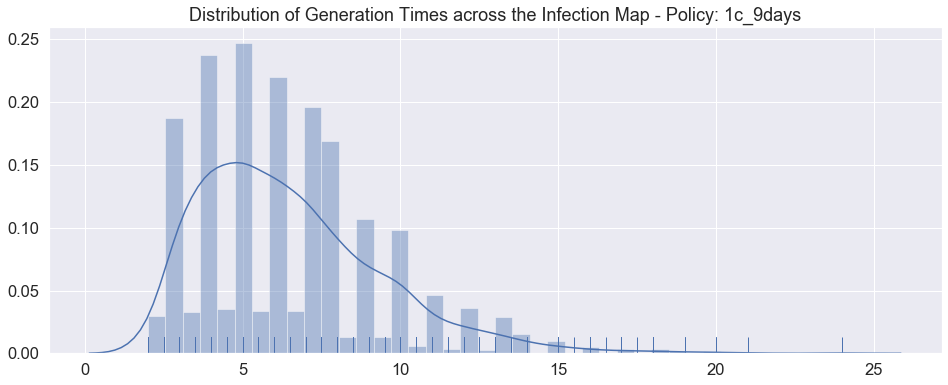

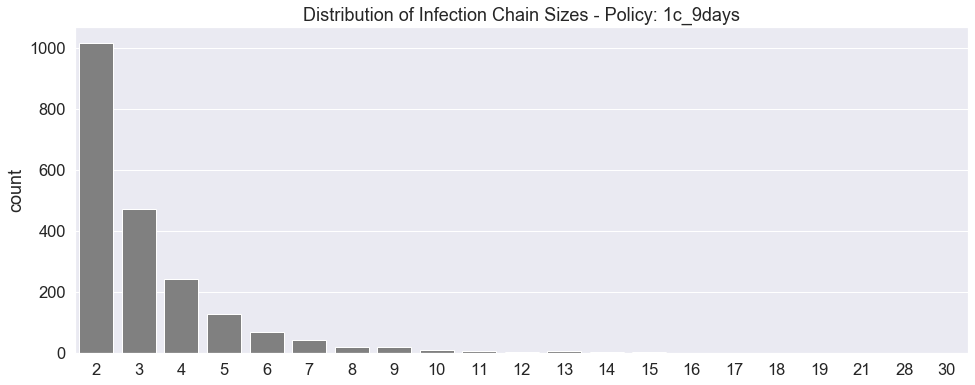

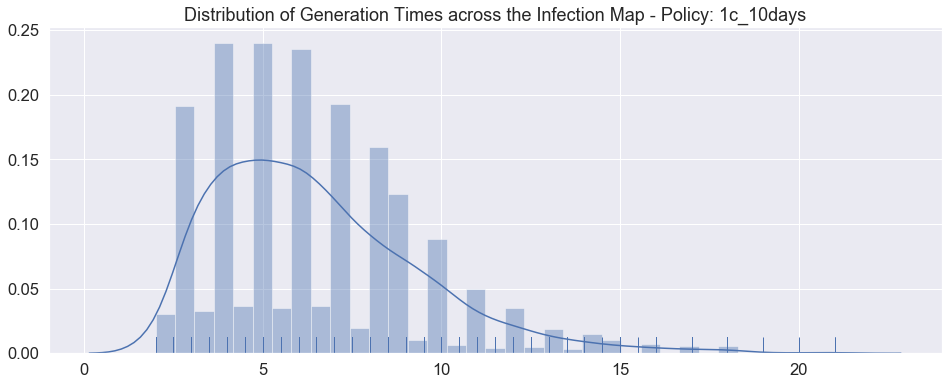

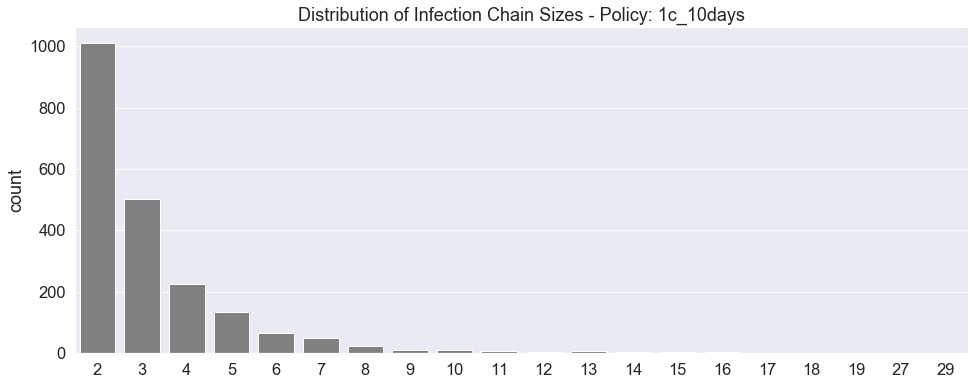

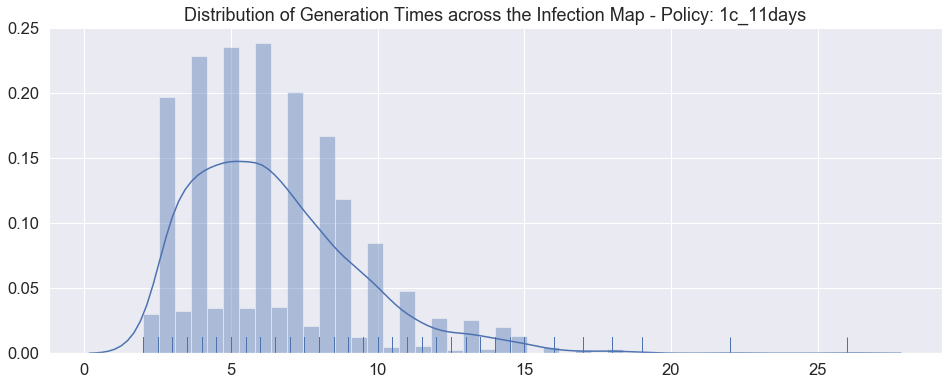

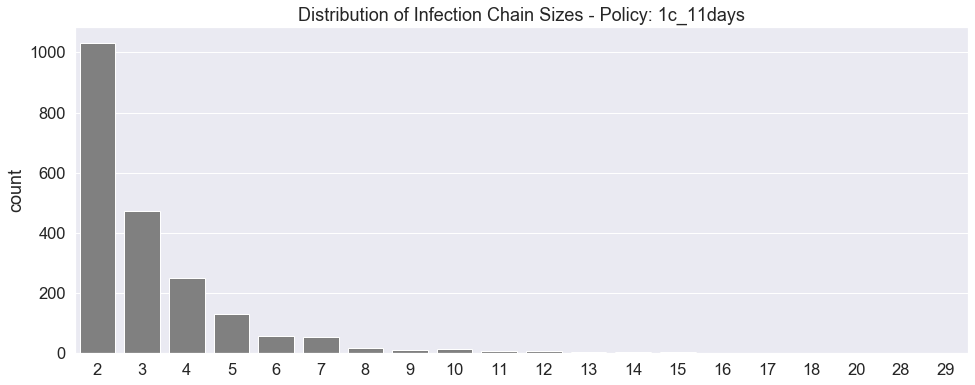

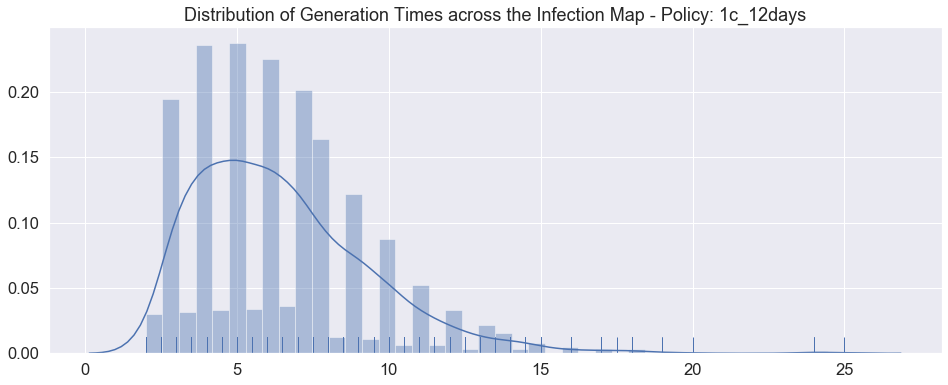

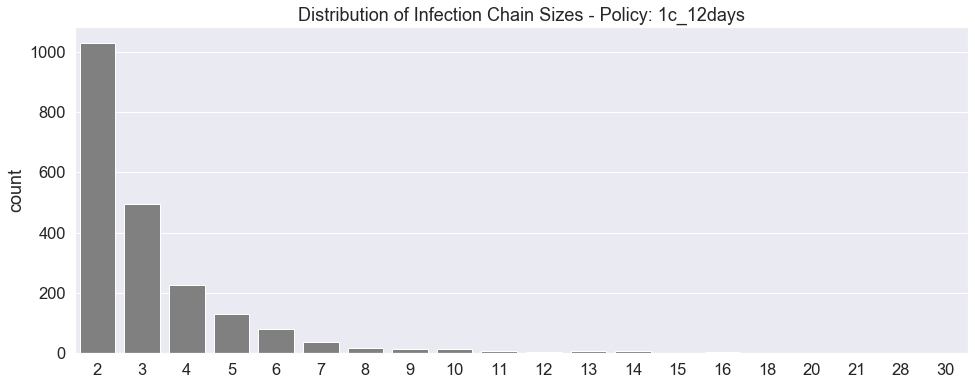

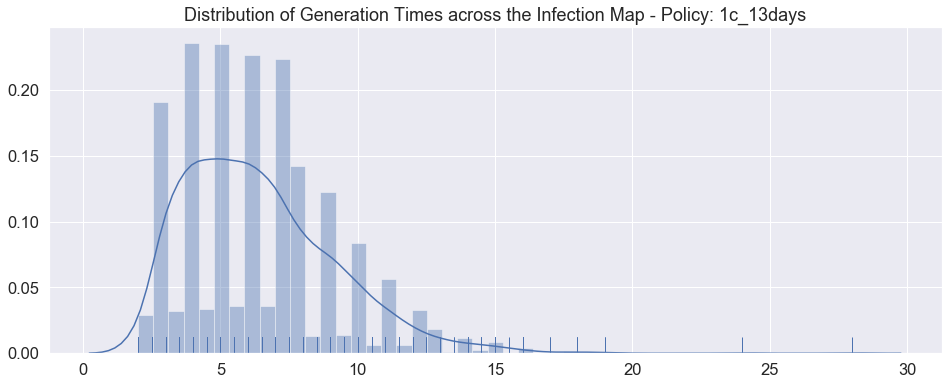

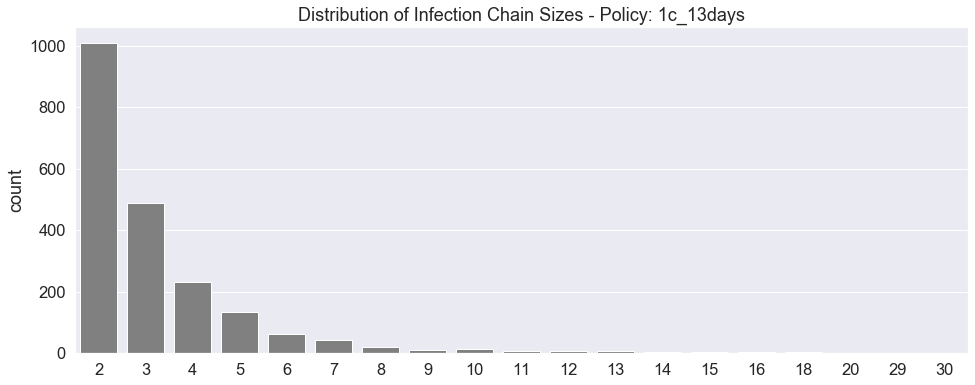

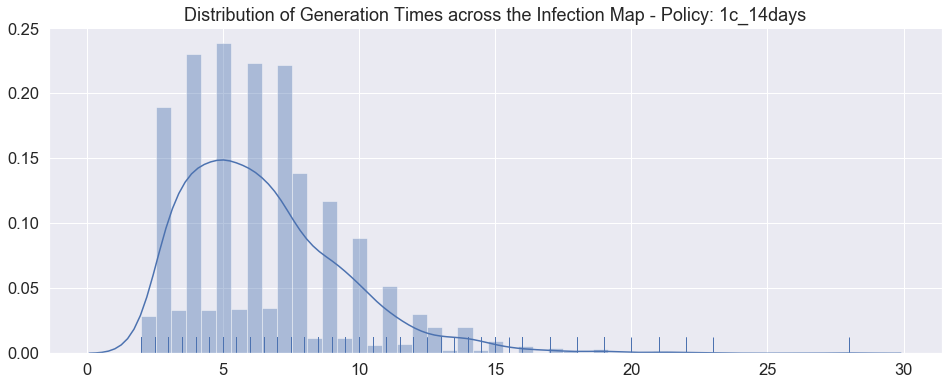

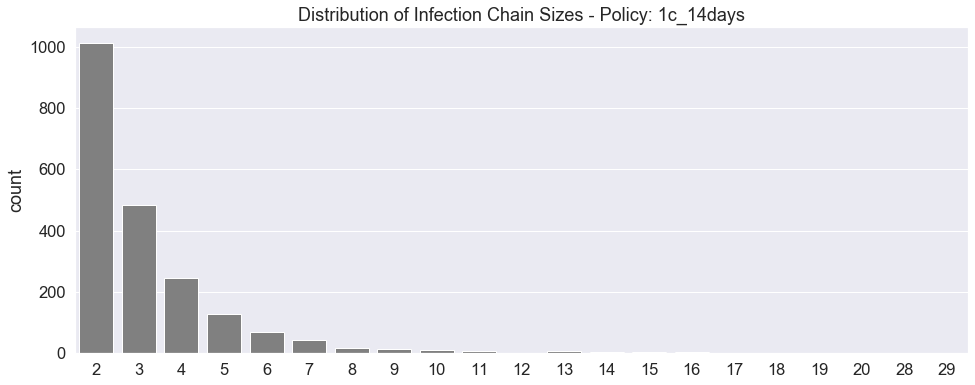

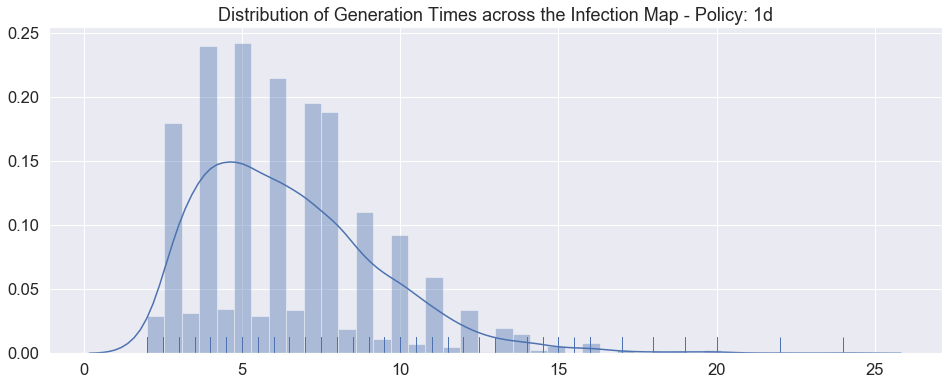

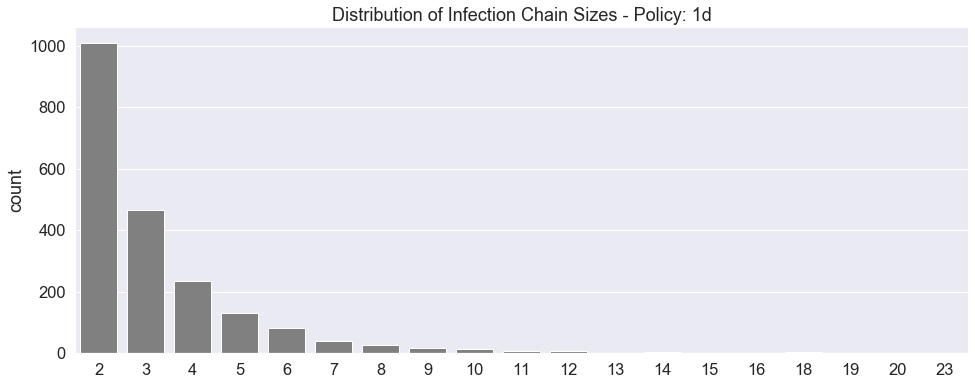

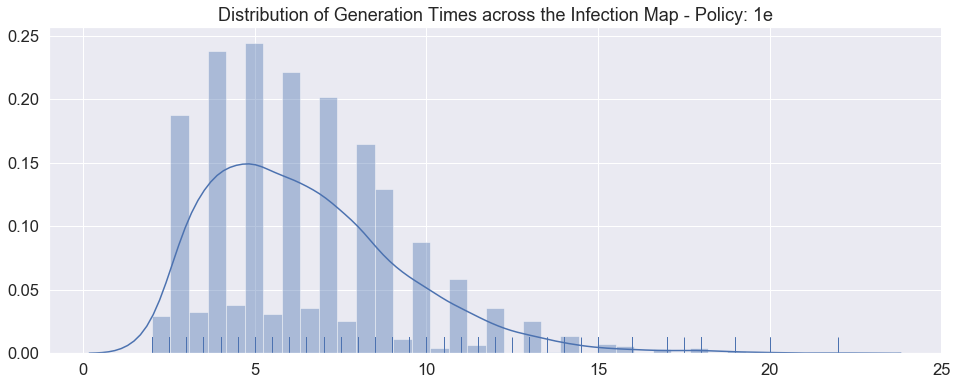

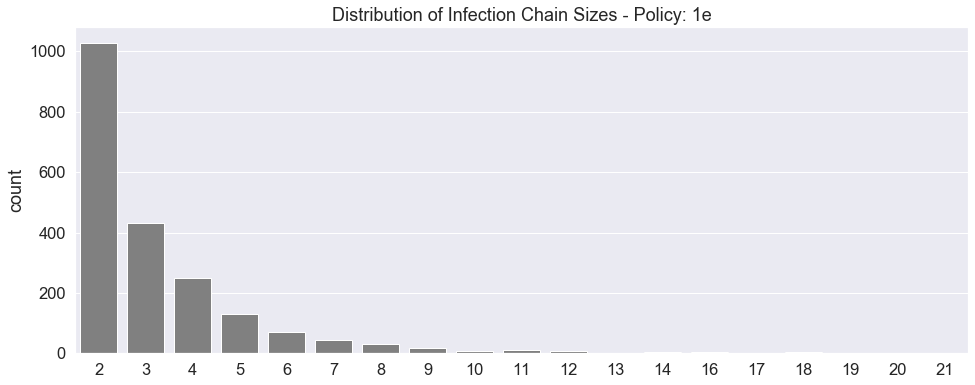

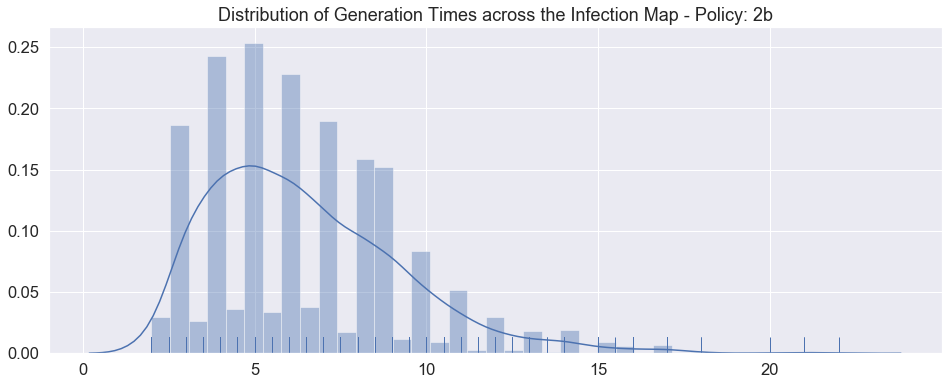

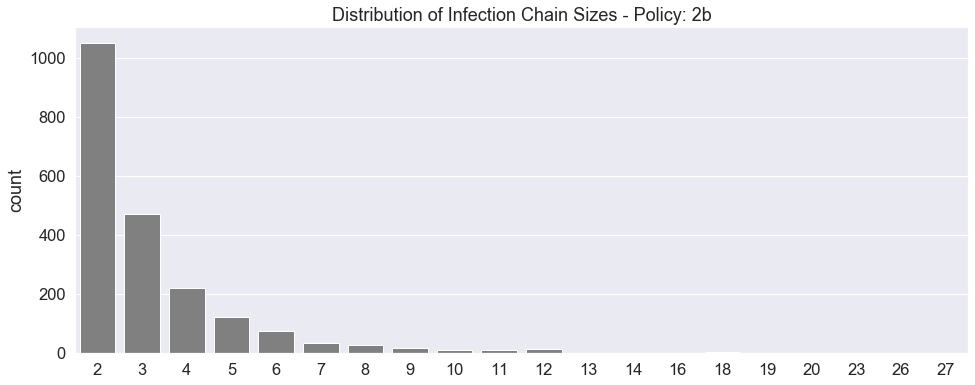

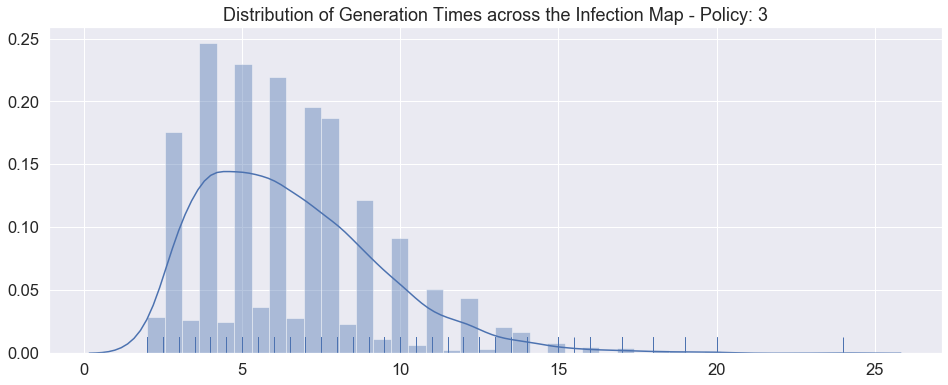

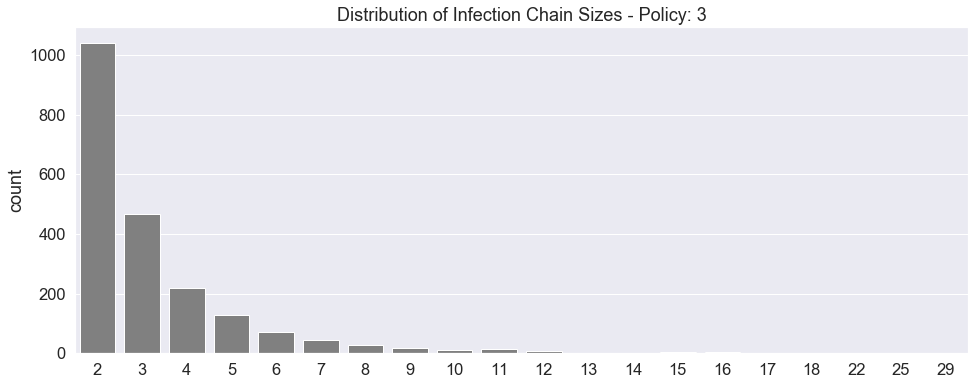

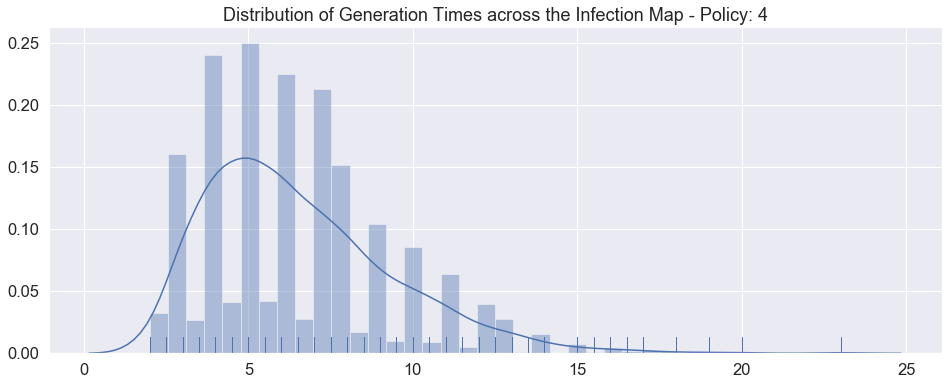

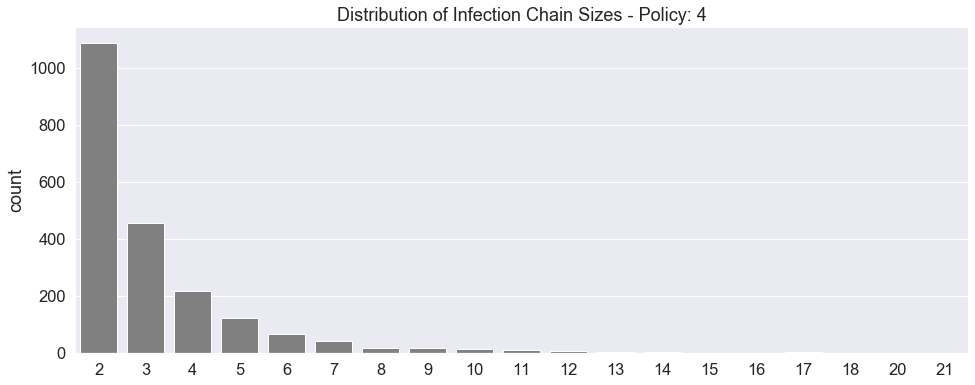

In [38]:
# Let's create a reader for the file readers

rootPath = "../../data/2020_07_29_multiScenarios/"

#policyFileNameExt = ["0","1a","1b","1c_0days", "1c_1days", "1c_2days", "1c_3days", "1c_4days", "1c_5days", "1c_6days", "1c_7days", "1c_8days", "1c_9days", "1c_10days", "1c_11days", "1c_12days", "1c_13days", "1c_14days", "1d", "1e", "2b", "3", "4"]
policyFileNameExt = ["1c_9days", "1c_10days", "1c_11days", "1c_12days", "1c_13days", "1c_14days", "1d", "1e", "2b", "3", "4"]


#policyFileNameExt = ["0","1a","1b"]

#graphProcessingResults = []

for policyName in policyFileNameExt:
    eventFileName = rootPath + "events/events_" + policyName + ".csv"
    infectionMapFileName = rootPath + "infectionMaps/infectionMap_" + policyName + ".txt"
    #loadEventDataFilesToDataFrames(eventFileName)
    #conversionResult = convertInfectionMapToNetworkXGraph('../../data/2020_07_01_newSet/infectionMap.txt')
    print(eventFileName)
    print(infectionMapFileName)
    loadEventDataFilesToDataFrames(eventFileName)
    conversionResult = convertInfectionMapToNetworkXGraph(infectionMapFileName)
    graphProcessingResults.append(conversionResult)
    
    sns.set(font="Helvetica")
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(16, 6))
    plotGen = sns.distplot(conversionResult[1], rug=True).set_title("Distribution of Generation Times across the Infection Map - Policy: " + policyName);
    #plt.show()
    plt.savefig("Outputs/generationTime-" + policyName + ".png")
    
    G = conversionResult[0]
    componentSizes = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
    
    sns.set(font="Helvetica")
    sns.set(font_scale=1.5)
    plt.figure(figsize=(16, 6))
    #plotComp = sns.distplot(componentSizes, rug=True).set_title("Distribution of Infection Chain Sizes - Policy: " + policyName);
    sns.countplot(componentSizes, color = 'gray').set_title("Distribution of Infection Chain Sizes - Policy: " + policyName);
    #plt.show()
    plt.savefig("Outputs/components-" + policyName + ".png")

In [44]:
policyFileNameExt = ["0","1a","1b","1c_0days", "1c_1days", "1c_2days", "1c_3days", "1c_4days", "1c_5days", "1c_6days", "1c_7days", "1c_8days", "1c_9days", "1c_10days", "1c_11days", "1c_12days", "1c_13days", "1c_14days", "1d", "1e", "2b", "3", "4"]

componentSizeCollection = []
for i, policyName in enumerate(policyFileNameExt):
    print(policyName)
    componentSizes = [len(c) for c in sorted(nx.weakly_connected_components(graphProcessingResults[i][0]), key=len, reverse=True)]
    componentSizeCollection
#graphProcessingResults[0][1]

[8.0,
 10.0,
 4.0,
 6.0,
 5.0,
 8.0,
 5.0,
 13.0,
 4.0,
 9.0,
 5.0,
 6.0,
 3.0,
 4.0,
 6.0,
 2.0,
 8.5,
 7.0,
 7.0,
 7.0,
 10.0,
 7.0,
 3.0,
 5.0,
 5.0,
 14.0,
 9.0,
 4.0,
 2.0,
 6.0,
 6.0,
 5.0,
 6.0,
 5.0,
 4.0,
 7.0,
 6.0,
 13.0,
 6.0,
 2.0,
 3.0,
 3.0,
 6.0,
 6.0,
 5.0,
 8.5,
 7.0,
 17.0,
 3.0,
 7.0,
 9.0,
 6.0,
 9.0,
 4.0,
 3.0,
 3.5,
 18.0,
 4.0,
 2.5,
 5.0,
 4.0,
 5.0,
 5.0,
 6.0,
 6.0,
 3.0,
 10.5,
 3.0,
 3.0,
 4.0,
 2.0,
 7.0,
 9.0,
 7.0,
 5.0,
 6.0,
 8.0,
 3.0,
 6.0,
 2.0,
 4.0,
 3.0,
 10.0,
 6.0,
 3.0,
 12.0,
 8.0,
 12.0,
 3.0,
 4.5,
 5.0,
 16.0,
 6.0,
 11.0,
 4.0,
 3.0,
 4.5,
 9.0,
 8.0,
 11.0,
 4.0,
 4.5,
 3.0,
 2.0,
 4.0,
 10.0,
 9.5,
 10.0,
 5.0,
 8.0,
 6.0,
 5.0,
 4.0,
 3.0,
 7.0,
 10.0,
 5.0,
 6.0,
 7.0,
 4.5,
 13.0,
 8.0,
 7.0,
 5.0,
 2.0,
 5.0,
 4.0,
 5.0,
 8.5,
 12.0,
 8.5,
 8.5,
 9.0,
 7.0,
 3.0,
 6.0,
 17.0,
 8.0,
 6.0,
 3.0,
 7.0,
 3.0,
 4.0,
 5.0,
 6.0,
 10.0,
 7.0,
 6.0,
 8.0,
 8.5,
 3.0,
 3.0,
 4.5,
 5.0,
 4.5,
 3.0,
 3.0,
 3.0,
 7.0,
 7.5,
 4.0,
 5.0,
 4.5,
 

In [35]:

conversionResult = convertInfectionMapToNetworkXGraph('../../data/2020_07_01_newSet/infectionMap.txt')
G = conversionResult[0]
#G = convertInfectionMapToNetworkXGraph('../../data/infectionMap_NoRandom.txt')

In [36]:
G

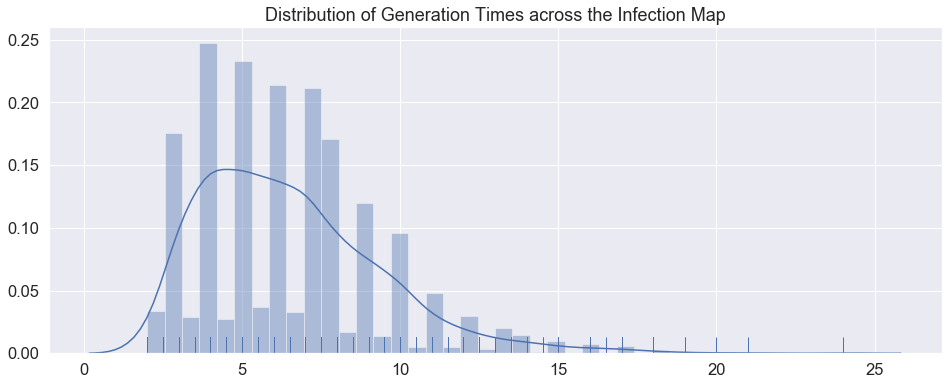

In [37]:
sns.set(font="Helvetica")
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 6))
sns.distplot(conversionResult[1], rug=True).set_title("Distribution of Generation Times across the Infection Map");


In [187]:
pd.DataFrame(conversionResult[1]).describe()

,0
count,3039.000000
mean,6.523527
std,2.866262
min,2.000000
25%,4.000000
50%,6.000000
75%,8.000000
max,24.000000


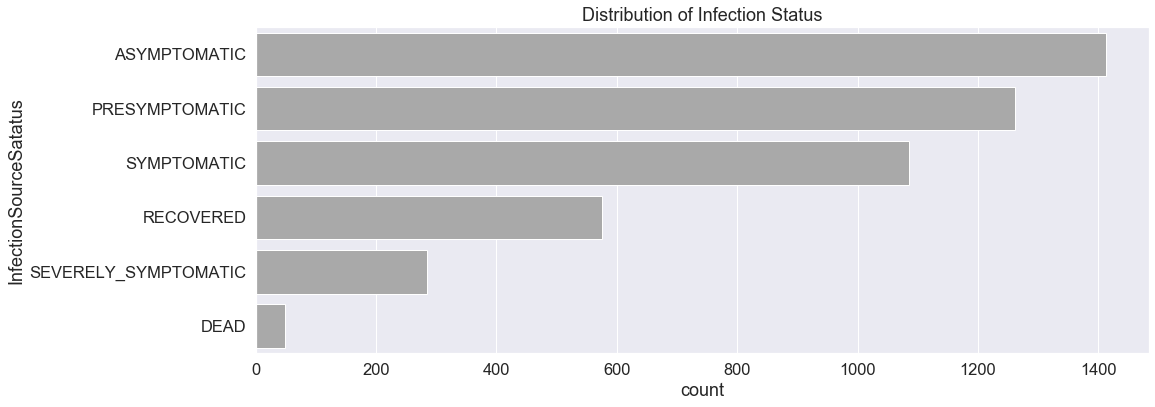

In [6]:
infectionSourceStatusDistributions = conversionResult[2]
plot_df = pd.DataFrame(infectionSourceStatusDistributions,columns =['InfectionSourceSatatus']) 

sns.set(font="Helvetica")
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 6))
sns.countplot(data = plot_df, y = "InfectionSourceSatatus", color="#A9A9A9", order = plot_df['InfectionSourceSatatus'].value_counts().index).set_title("Distribution of Infection Status");
#sns.catplot(y="newStatus", kind="count", data=infectionSourceStatusDistributions, color="#A9A9A9");

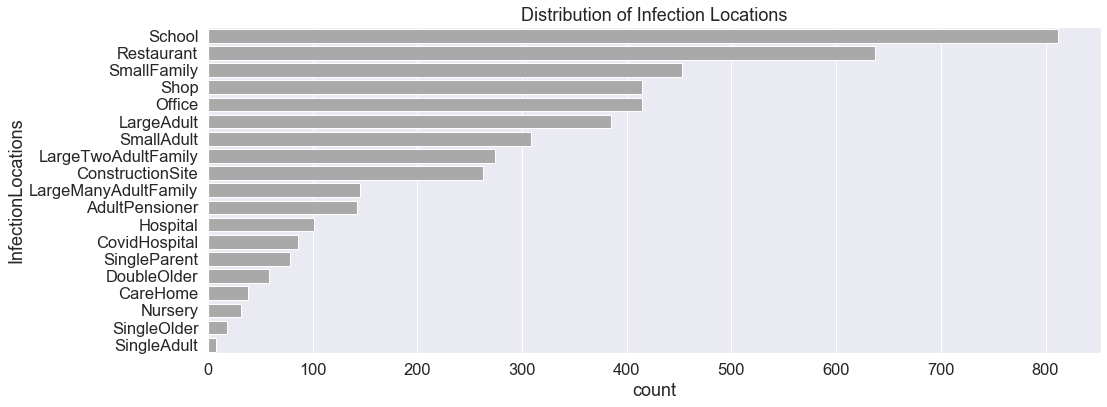

In [7]:
infectionLocationDistributions = conversionResult[3]
plot_df = pd.DataFrame(infectionLocationDistributions,columns =['InfectionLocations']) 

sns.set(font="Helvetica")
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 6))
sns.countplot(data = plot_df, y = "InfectionLocations", color="#A9A9A9", order = plot_df['InfectionLocations'].value_counts().index).set_title("Distribution of Infection Locations");
#sns.catplot(y="newStatus", kind="count", data=infectionSourceStatusDistributions, color="#A9A9A9");

In [27]:
nx.write_graphml_lxml(G, "InfectionMap_Paul_Full_extended.graphml")

# Working with the (loosely connected) components 

In [28]:
componentSizes = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
len (componentSizes)

2108

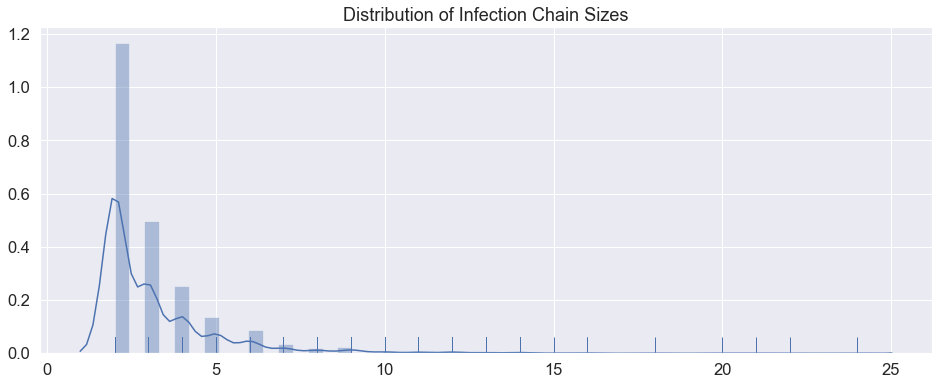

In [94]:
sns.set(font="Helvetica")
sns.set(font_scale=1.5)
plt.figure(figsize=(16, 6))
sns.distplot(componentSizes, rug=True).set_title("Distribution of Infection Chain Sizes");

In [29]:
l = [c for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]

In [32]:
numberOfComponents = 100
H = nx.compose_all([G.subgraph(l[c]) for c in np.arange(numberOfComponents)])

In [33]:
nx.write_graphml_lxml(H, "InfectionMap_Paul_100comp_extended.graphml")

In [35]:
#H1 = G.subgraph(l[0])
#H2 = G.subgraph(l[1])

In [36]:
#H = nx.compose(H1, H2)

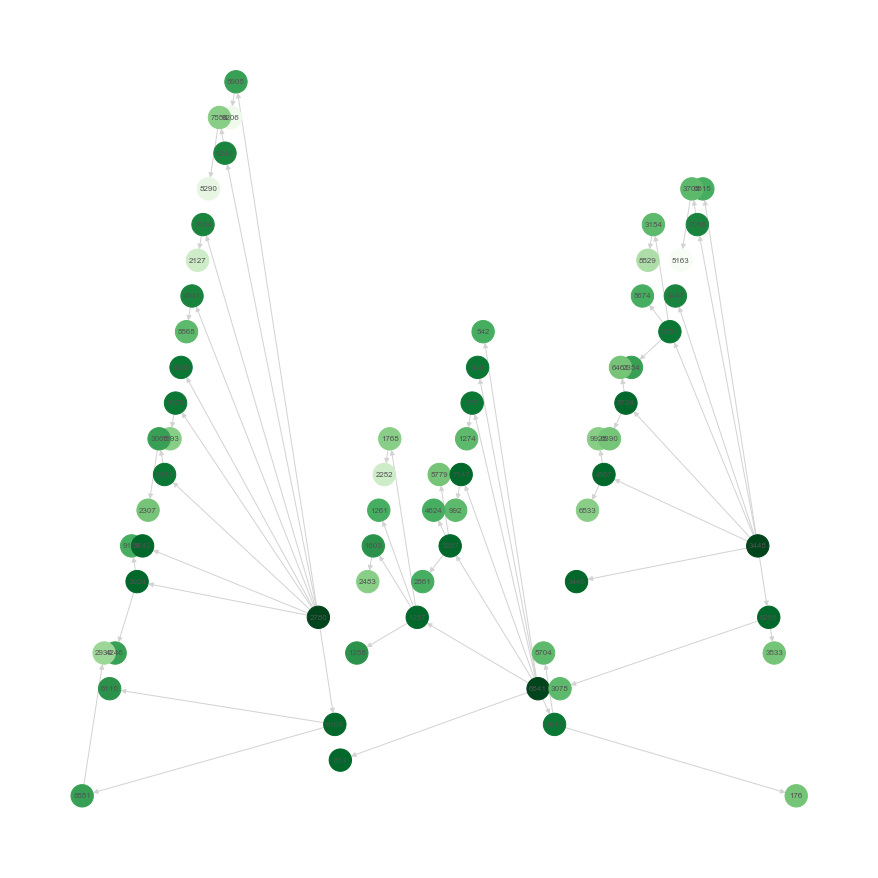

In [102]:
nodes = H.nodes(data=True)
plt.figure(1,figsize=(12,12))
colors = [v['infectionTime'] for u,v in nodes]
# #print(colors)
pos = nx.spring_layout(H, iterations = 1000)
pos = nx.planar_layout(H)
#pos = nx.shell_layout(H)

#kamada_kawai_layout
#pos = nx.kamada_kawai_layout(H)
nx.draw(H, pos=pos, cmap=plt.cm.Greens_r, node_color= colors, node_size = 500, edge_color = '#d3d3d3')
nx.draw_networkx_labels(H, pos=pos, font_size = 8, font_color = '#525252')
plt.show()

In [12]:
np.searchsorted([2, 5], 2, side='left')

0